<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/Siamese_network_on_edge_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle

In [ ]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/crop_img_arrays_32.npz', allow_pickle = True)
x, tx, gx = data['x'], data['tx'], data['g']

In [ ]:
x_data = np.array([np.reshape(np.array(i[1]), (32, 96, 1)) for i in x])
tx_data = np.array([np.reshape(np.array(i[1]), (32, 96, 1)) for i in tx])
g_data = np.array([np.reshape(np.array(i[1]), (32, 96, 1)) for i in gx])
x_data.shape, tx_data.shape, g_data.shape

((1505, 32, 96, 1), (905, 32, 96, 1), (100, 32, 96, 1))

In [ ]:
i = np.array([i[0] for i in x])
ti = np.array([i[0] for i in tx])
gi = np.array([i[0] for i in gx])
i

array([  1,   1,   1, ..., 301, 301, 301])

In [ ]:
ty = np.where(pd.Series(ti).isin(gi), 1, 0)

In [ ]:
# from re import X
def create_batch(batch_size=500):
    x_anchors = np.zeros((batch_size, 32, 96, 1))
    x_positives = np.zeros((batch_size, 32, 96, 1))
    x_negatives = np.zeros((batch_size, 32, 96, 1))
    
    for j in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_data.shape[0] - 1)
        x_anchor = x_data[random_index]

        pos_index = random.randint(0, x_data.shape[0] - 1)

        while pos_index == random_index or i[pos_index] != i[random_index]:
          pos_index = random.randint(0, x_data.shape[0] - 1)

        x_positive = x_data[pos_index]  # also for the same pallet block
        
        random_index_neg = random.randint(0, x_data.shape[0] - 1)

        while random_index_neg == random_index or i[random_index] == i[random_index_neg]:
          random_index_neg = random.randint(0, x_data.shape[0] - 1)
         
        x_negative = x_data[random_index_neg]
        
        x_anchors[j] = x_anchor
        x_positives[j] = x_positive
        x_negatives[j] = x_negative
        
    x_anchors = np.expand_dims(x_anchors, axis = 1)
    x_positives = np.expand_dims(x_positives, axis = 1)
    x_negatives = np.expand_dims(x_negatives, axis = 1)

    k = np.concatenate([x_anchors, x_positives, x_negatives], axis = 1)
        
    return k

In [ ]:
examples = create_batch(1)
examples.shape

(1, 3, 32, 96, 1)

In [ ]:
# Embedding model
emb_size = 64

# embedding_model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(emb_size, (3, 3), activation = 'relu', strides = 2, padding = 'same', input_shape = (32, 96, 1)),
#     tf.keras.layers.Conv2D(emb_size/2, (3, 3), activation = 'relu', strides = 2, padding = 'same'),
#     tf.keras.layers.Conv2D(emb_size/2, (3, 3), activation = "relu"),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(emb_size/2, activation = 'relu'),
#     tf.keras.layers.Dense(30, activation = 'sigmoid')
# ])

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', strides = 2, padding = 'same', input_shape = (32, 96, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', strides = 1, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(emb_size/2, (3, 3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30)
])

embedding_model.summary()

# input_layer1 = tf.keras.layers.Input(shape = tri_data.shape[2:])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 16, 48, 256)       2560      
                                                                 
 batch_normalization_29 (Bat  (None, 16, 48, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 48, 128)       295040    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 24, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 8, 24, 128)       512       
 chNormalization)                                                
                                                      

In [ ]:
# siamese network
siamese_input = tf.keras.Input(shape = (3, 32, 96, 1))
input_anchor =  siamese_input[:, 0]                                              #tf.keras.layers.Input(shape=(32, 96, 3))
input_positive = siamese_input[:, 1]                                             #tf.keras.layers.Input(shape=(32, 96, 3))
input_negative = siamese_input[:, 2]                                             #tf.keras.layers.Input(shape=(32, 96, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

embedding_anchor = k.expand_dims(embedding_anchor, 1)
embedding_negative = k.expand_dims(embedding_negative, 1)
embedding_positive = k.expand_dims(embedding_positive, 1)


output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1) 

model = tf.keras.models.Model(siamese_input, output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3, 32, 96,   0           []                               
                                1)]                                                               
                                                                                                  
 tf.__operators__.getitem_18 (S  (None, 32, 96, 1)   0           ['input_7[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_19 (S  (None, 32, 96, 1)   0           ['input_7[0][0]']                
 licingOpLambda)                                                                            

In [ ]:
# alpha = 0.05
alpha = 0.07
# alpha = 0.001
# pos = k.sqrt(k.mean((embedding_anchor - embedding_positive)**2, axis = 1))
# neg = k.sqrt(k.mean((embedding_anchor - embedding_negative)**2, axis = 1))

pos = k.mean((embedding_anchor - embedding_positive)**2, axis = 1)
neg = k.mean((embedding_anchor - embedding_negative)**2, axis = 1)

loss = k.mean(k.relu(pos - neg + alpha)) 

In [ ]:
batch_size = 10000
x_train = create_batch(batch_size)
x_train = np.array(x_train)
x_train.shape

(10000, 3, 32, 96, 1)

In [ ]:
# batch_size = 2048
epochs = 30
# steps_per_epoch = 25

model.add_loss(loss)


model.compile(optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

history = model.fit(
    x_train,
    batch_size = 125,
    epochs=epochs, verbose=True, callbacks = [callback], validation_split = 0.2)

Epoch 1/30
64/64 [==============================] - 10s 135ms/step - loss: 0.1080 - val_loss: 0.0340
Epoch 2/30
64/64 [==============================] - 8s 121ms/step - loss: 0.0366 - val_loss: 0.0278
Epoch 3/30
64/64 [==============================] - 8s 128ms/step - loss: 0.0283 - val_loss: 0.0237
Epoch 4/30
64/64 [==============================] - 8s 120ms/step - loss: 0.0233 - val_loss: 0.0203
Epoch 5/30
64/64 [==============================] - 8s 120ms/step - loss: 0.0210 - val_loss: 0.0162
Epoch 6/30
64/64 [==============================] - 8s 125ms/step - loss: 0.0183 - val_loss: 0.0156
Epoch 7/30
64/64 [==============================] - 8s 125ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 8/30
64/64 [==============================] - 8s 124ms/step - loss: 0.0159 - val_loss: 0.0134
Epoch 9/30
64/64 [==============================] - 8s 125ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 10/30
64/64 [==============================] - 8s 125ms/step - loss: 0.0147 - val_loss: 0.015

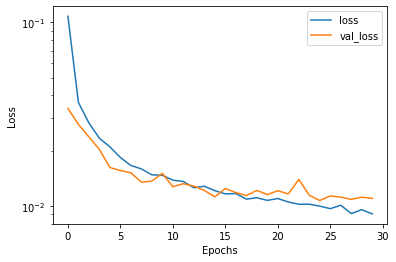

In [ ]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
x[0]

NameError: ignored

In [ ]:
x_predict = embedding_model.predict(x_data)
g_predict = embedding_model.predict(g_data)
t_predict = embedding_model.predict(tx_data)

29/29 [==============================] - 0s 3ms/step


In [ ]:
bool_ls = []
ls = []
for n in range(0, t_predict.shape[0]):
  # if ty[n] == 1: print(n) 
  if ty[n] == 1: continue
  p_2 = t_predict[n]
  sub = g_predict - p_2
  dist = np.mean((sub)**2, axis = 1)
  min_index = np.argsort(dist)
  for i in range(len(min_index)):
    if gi[min_index[i]] == ti[n]:
      ls.append(1)
  # if (gi[min_index] == ti[n]).any(): bool_ls.append(1)
  else: bool_ls.append(0)

In [ ]:
len(ty)

905

In [ ]:
bool_ls[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
t_predict.shape[0], len(ty)

(905, 905)

In [ ]:
bool_ls = []

for i in np.where(ty == 1)[0]:
  if (gi[np.argsort(np.mean((g_predict - t_predict[i]) **2, axis = 1))][:5] == ti[i]).any():
    bool_ls.append(1)

In [ ]:
g_predict_normal = np.random.normal(0, 1, g_predict.shape)

In [ ]:
len(bool_ls)/400

0.1425

In [ ]:
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

In [ ]:
bool_ls = []

for i in np.where(ty == 1)[0]:
  index = np.argsort(np.mean((g_predict - t_predict[i]) **2, axis = 1))
  ls_1 = zerolistmaker(len(index))
  # print(np.where(gi[index] == ti[i]))
  ls_1[np.where(gi[index] == ti[i])[0][0]] = 1
  bool_ls.append(ls_1)

In [ ]:
np.unique(bool_ls[0], return_counts = True)

(array([0, 1]), array([99,  1]))

In [ ]:
len(bool_ls[0])

100

<BarContainer object of 100 artists>

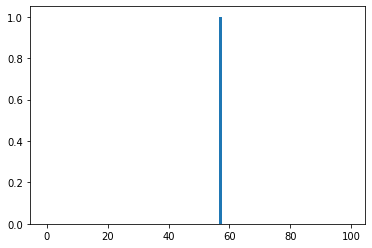

In [ ]:
plt.bar(x = pd.Series(bool_ls[10]).index, height = pd.Series(bool_ls[10]))

In [ ]:
np.where(gi[index] == ti[i])[0][0]

90

In [ ]:
ls_1[np.where(gi[index] == ti[i])[0][0]] = 1

In [ ]:
np.unique(ls_1, return_counts = True)

(array([0, 1]), array([ 4, 96]))

In [ ]:
len(bool_ls)

57

In [ ]:
57/905

0.06298342541436464

In [ ]:
for i in range(t_predict.shape[0]):
  if ty[i] == 1 : continue
  print(i)
  # break
  if (gi[np.argsort(np.mean((g_predict - t_predict[i]) **2, axis = 1))] == ti[i]).any():
    print(1)

In [ ]:
if ty[2] == 1:
  print(1)

1


In [ ]:
gi[56]

369

In [ ]:
np.where(ty == 1)

In [ ]:
import matplotlib.pyplot as plt

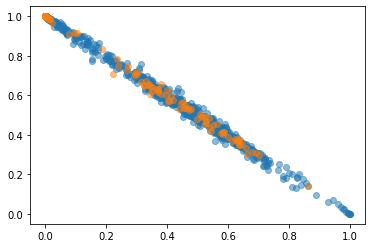

In [ ]:
plt.scatter(t_predict[:,0], t_predict[:,1], alpha = 0.5)
plt.scatter(g_predict[:,0], g_predict[:,1], alpha = 0.5)

In [ ]:
t_pre

In [ ]:
t_predict.shape

(905, 10)

In [ ]:
p_2 = t_predict[0]

In [ ]:
p_2 = t_predict[ty == 1][10]

In [ ]:
np.argsort(np.mean((g_predict - p_2)**2, axis =1))[:1]

array([9])

In [ ]:
t_predict.shape[0]

int

In [ ]:
gi[7]

311

In [ ]:
for i in range(0, t_predict.shape[0]):
  if (gi[7] == ti[i]).any(): print(1)
  else: continue 

1
1
1
1


In [ ]:
np.where(ti == 311)

(array([38, 39, 40, 41]),)

In [ ]:
gi[1] == ti[1]

False

In [ ]:
(gi[9] == ti[9]).any()

False

In [ ]:
gi[min_index]

array([393])

In [ ]:
ti[min_index]

array([320])

In [ ]:
np.mean(bool_ls)

0.0